In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image
import tensorflow as tf
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
main_dirction_path = '../input/chest-xray-pneumonia/chest_xray'
print(os.listdir(main_dirction_path))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [4]:
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'
val_folder_path = main_dirction_path + '/val/'

In [5]:
os.listdir(train_folder_path)

['PNEUMONIA', 'NORMAL']

In [6]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

In [7]:
print(len(os.listdir(train_n_path))) #length of normal training images
print(len(os.listdir(train_p_path))) #length of pneumonia training images 
print('TOTAL TRAIN IMAGES:', len(os.listdir(train_n_path)) + len(os.listdir(train_p_path)))

1341
3875
TOTAL TRAIN IMAGES: 5216


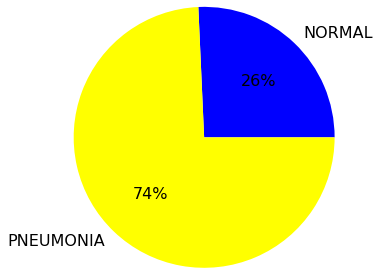

In [9]:
x = np.array([len(os.listdir(train_n_path)),len(os.listdir(train_p_path))])
labels = ['NORMAL', 'PNEUMONIA']
colors = {'NORMAL': 'Blue','PNEUMONIA': 'yellow' }
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, colors = [colors[key] for key in labels], textprops={'fontsize': 16})
plt.show()

(-0.5, 1223.5, 583.5, -0.5)

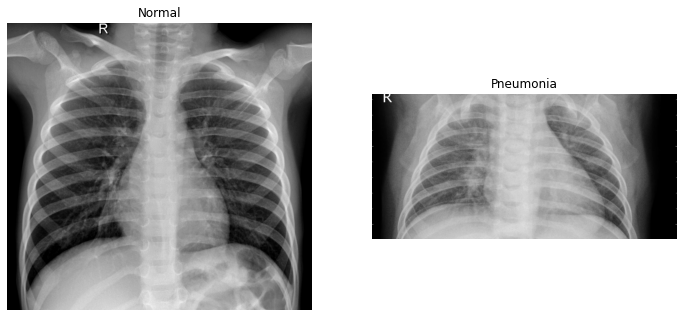

In [10]:
random_normal= np.random.randint(0,len(os.listdir(train_n_path))) 
normal_img = os.listdir(train_n_path)[random_normal]
normal_img_address = train_n_path+normal_img

# Choose random image from pneumonia folder
random_pneumonia = np.random.randint(0,len(os.listdir(train_p_path)))
pneumonia_img =  os.listdir(train_p_path)[random_pneumonia]
pneumonia_img_address = train_p_path+pneumonia_img

#Load 2 images
normal_load = Image.open(normal_img_address)
pneumonia_load = Image.open(pneumonia_img_address)

#Visulaizaion 
figure = plt.figure(figsize= (12,12))
img1 = figure.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load, cmap = 'gray')
img1.set_title('Normal')
plt.axis("off")

img2 = figure.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load, cmap = 'gray')
img2.set_title('Pneumonia')
plt.axis("off")

In [11]:
normal_load.size

(1850, 1746)

In [12]:
pneumonia_load.size

(1224, 584)

In [13]:
def show_normal_images (number):
    plt.figure(figsize=(16,16))
    for n in range(number):
        normal_img = os.listdir(train_n_path)[n]
        normal_img_address = train_n_path+normal_img
        normal_load = Image.open(normal_img_address)
        ax = plt.subplot(5,5,n+1)
        plt.imshow(normal_load, cmap ='gray')
        plt.title("NORMAL")
        plt.axis("off")
        
def show_pneumonia_images (number):
    plt.figure(figsize=(16,16))
    for n in range(number):
        pneumonia_img =  os.listdir(train_p_path)[n]
        pneumonia_img_address = train_p_path+pneumonia_img
        pneumonia_load = Image.open(pneumonia_img_address)
        ax = plt.subplot(5,5,n+1)
        plt.imshow(pneumonia_load, cmap ='gray')
        plt.title("PNEUMONIA")
        plt.axis("off")

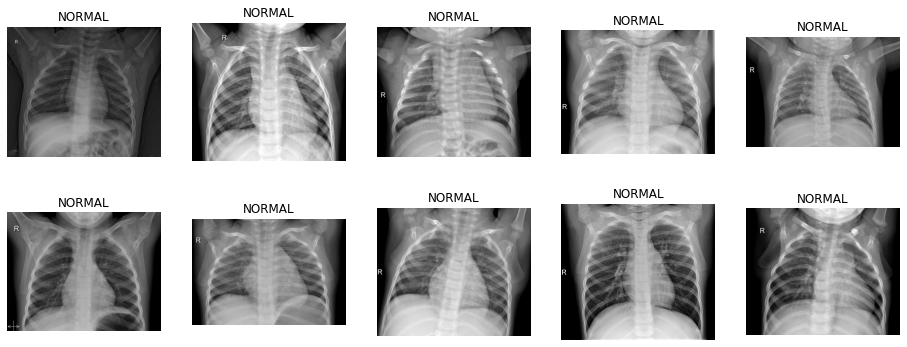

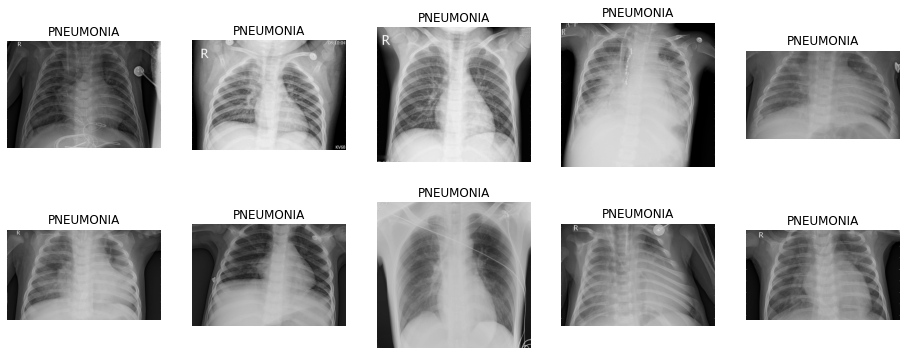

In [14]:
show_normal_images(10)
show_pneumonia_images(10)

In [16]:
img = np.asarray(normal_load)
image_eq = exposure.equalize_hist(img)

(-0.5, 1849.5, 1745.5, -0.5)

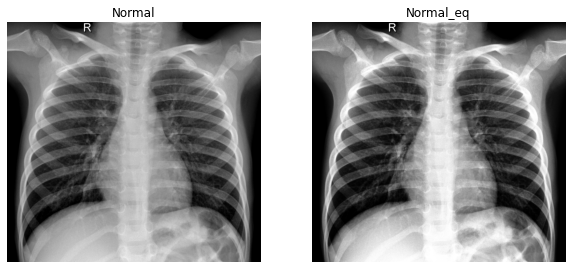

In [17]:
figure1 = plt.figure(figsize= (10,10))
img_1 = figure1.add_subplot(1,2,1)
img_plot = plt.imshow(img, cmap = 'gray')
img_1.set_title('Normal')
plt.axis("off")

img2 = figure1.add_subplot(1, 2, 2)
img_plot = plt.imshow(image_eq, cmap = 'gray')
img2.set_title('Normal_eq')
plt.axis("off")

In [18]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [19]:
os.listdir(train_folder_path)

['PNEUMONIA', 'NORMAL']

In [20]:
TRAIN_IMG_COUNT = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
COUNT_NORMAL = len(os.listdir(train_n_path))
COUNT_PNEUMONIA = len(os.listdir(train_p_path))

weight_for_0 = TRAIN_IMG_COUNT / (2 * COUNT_NORMAL)
weight_for_1 = TRAIN_IMG_COUNT / (2 * COUNT_PNEUMONIA)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [21]:
img_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split = 0.25,
                                   horizontal_flip = True)


training_set = img_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train',
                                                 target_size = (256, 256),
                                                 batch_size = 5,
                                                 color_mode='grayscale',
                                                 subset='training',
                                                 class_mode = 'binary')

validation_generator = img_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/train',
                                                        target_size=(256, 256),
                                                        batch_size=5,
                                                        subset="validation",
                                                        color_mode='grayscale',
                                                        class_mode='binary')

test_set = img_datagen.flow_from_directory('../input/chest-xray-pneumonia/chest_xray/test',
                                            target_size = (256, 256),
                                            batch_size = 5,
                                            color_mode='grayscale',
                                            shuffle=False,
                                            class_mode = 'binary')

Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-12-18 18:19:06.870851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 18:19:06.871831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 18:19:07.001450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 18:19:07.002492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 18:19:07.003369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      1

In [24]:
cnn_model = model.fit(training_set,
                      epochs = 10 ,
                      steps_per_epoch = training_set.samples // 5,
                      validation_data = validation_generator,
                      validation_steps = validation_generator.samples // 5,
                      class_weight = class_weight 
                      )

2022-12-18 18:19:31.256419: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-18 18:19:33.780805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


782/782 [==============================] - 128s 150ms/step - loss: 0.4313 - accuracy: 0.8032 - val_loss: 0.9117 - val_accuracy: 0.7723
Epoch 2/10
782/782 [==============================] - 87s 111ms/step - loss: 0.3583 - accuracy: 0.8506 - val_loss: 13.0814 - val_accuracy: 0.4385
Epoch 3/10
782/782 [==============================] - 86s 110ms/step - loss: 0.3694 - accuracy: 0.8385 - val_loss: 0.2217 - val_accuracy: 0.9146
Epoch 4/10
782/782 [==============================] - 87s 111ms/step - loss: 0.3486 - accuracy: 0.8493 - val_loss: 0.2685 - val_accuracy: 0.8854
Epoch 5/10
782/782 [==============================] - 88s 112ms/step - loss: 0.3472 - accuracy: 0.8562 - val_loss: 0.4182 - val_accuracy: 0.8192
Epoch 6/10
782/782 [==============================] - 86s 110ms/step - loss: 0.3342 - accuracy: 0.8628 - val_loss: 0.7405 - val_accuracy: 0.7792
Epoch 7/10
782/782 [==============================] - 86s 110ms/step - loss: 0.3569 - accuracy: 0.8508 - val_loss: 0.3660 - val_accuracy: 0

<AxesSubplot:>

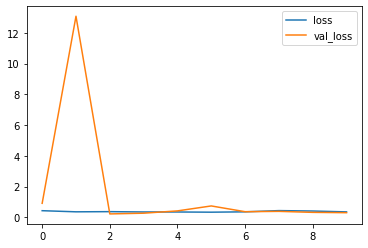

In [26]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

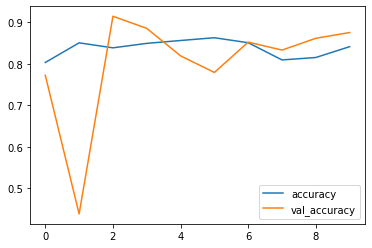

In [27]:
losses[['accuracy','val_accuracy']].plot()

In [28]:
loss, acc = model.evaluate(test_set)

125/125 [==============================] - 12s 96ms/step - loss: 0.3584 - accuracy: 0.8542


In [29]:
model.save('CNN_PNEUMONIA.h5')

In [30]:
Predections = model.predict(test_set)

In [31]:
Predections = (Predections>0.5).astype(np.int)

In [32]:
print(classification_report(test_set.classes, Predections, target_names = ['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.82      0.74      0.77       234
   Pneumonia       0.85      0.90      0.88       390

    accuracy                           0.84       624
   macro avg       0.83      0.82      0.83       624
weighted avg       0.84      0.84      0.84       624



In [33]:
confusion_matrix(test_set.classes, Predections>0.5)

array([[172,  62],
       [ 38, 352]])

<AxesSubplot:>

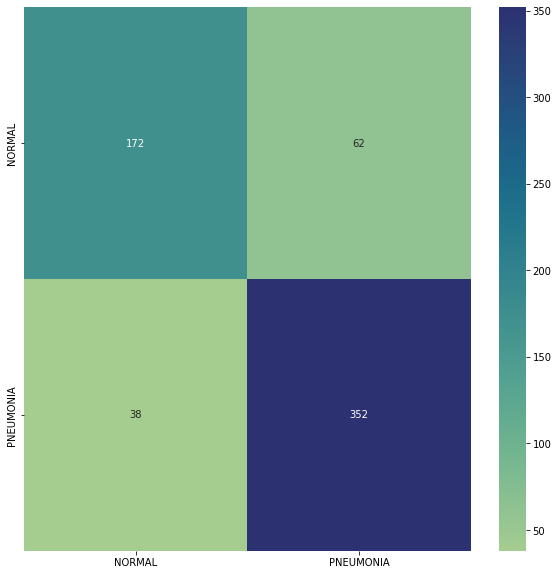

In [34]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(test_set.classes, Predections>0.5),cmap= "crest", 
            annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [35]:
correct_pred = np.nonzero(Predections == test_set.classes)[0]
incorrect_pred = np.nonzero(Predections != test_set.classes)[0]

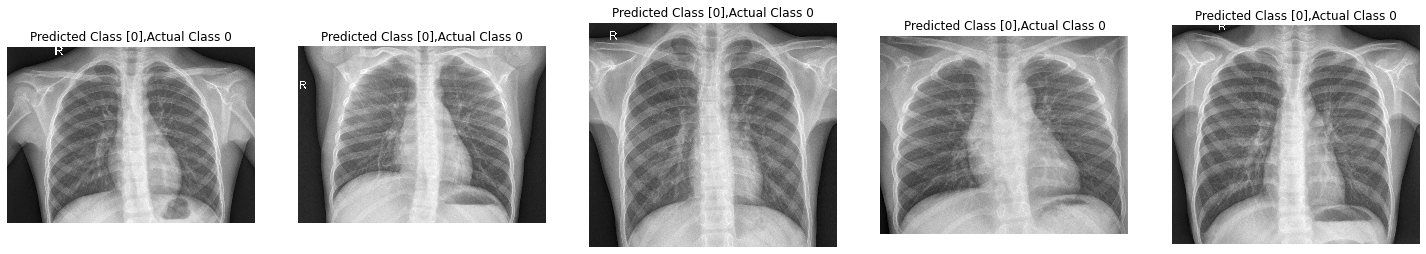

In [36]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect_pred[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(Image.open(test_set.filepaths[i]), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(Predections[c], test_set.classes[c]))
    plt.tight_layout()
    plt.axis("off")
    i += 1